In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
hep.style.use(hep.style.CMS)

import hist as hist2
from coffea import processor
from coffea.analysis_tools import Weights, PackedSelection

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")

In [49]:
def invariant_mass(jet1, jet2):
    """di-jet invariant mass"""
    return np.sqrt(2 * jet1.pt * jet2.pt * (np.cosh(jet1.eta - jet2.eta) - np.cos(jet1.phi - jet2.phi)))


def normalize(val, cut=None):
    """normalize arrays after a cut or selection"""
    if cut is None:
        ar = ak.to_numpy(ak.fill_none(val, np.nan))
        return ar
    else:
        ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
        return ar
    
    
class BackgroundProcessor(processor.ProcessorABC):
    def __init__(self):
        
        # here we define an output
        self.make_output = lambda: {
            'sumw': 0.,
            "jet_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(30, 0, 1000, name='H', label='$H_T$ [GeV]'),
                hist2.axis.Regular(50, 30, 1000, name="jet_pt", label=r"Jet $p_T$ [GeV]"),
                hist2.axis.Regular(20, -5, 5, name="jet_eta", label=r"Jet $\eta$"),
                hist2.axis.Regular(30, 0, 200, name="jet_mass", label=r"Jet $m$ [GeV]"),
                hist2.storage.Weight(),
            ),
            "met_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(50, 0, 1000, name="met_pt", label=r"$p_T^{miss}$ [GeV]"),
                hist2.axis.Regular(20, 0, 4, name="minDeltaPhi", label="min $|\Delta \phi (p_T^{miss}, J_i)|$"),
                hist2.storage.Weight(),
            ),
            "dijet_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(30, 0, 4, name='leadingJetsDphi', label='$|\Delta \phi (J_1, J_2)|$'),
                hist2.axis.Regular(30, 0, 5000, name='invariantMass', label=r"$m_{jj}^{max}$ [GeV]"),
                hist2.axis.Regular(20, 0, 10, name='maxDeltaEta', label="max $|\Delta \eta (J_i, J_j)|$"),
                hist2.storage.Weight(),
            ),
            "cutflow": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.IntCategory([0, 1, 2, 3], name='cut', growth=True),
                hist2.axis.Regular(50, 0, 1000, name="met_pt", label=r"$p_T^{miss}$ [GeV]"),
                hist2.storage.Weight(),
            ),
            "cutflow_maxDeltaEta": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.IntCategory([0, 1, 2, 3], name='cut', label='Cut index', growth=True),
                hist2.axis.Regular(20, 0, 10, name='maxDeltaEta', label="max $|\Delta \eta (J_i, J_j)|$"),
                hist2.storage.Weight(),
            ),
            "cutflow_invariantMass": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.IntCategory([0, 1, 2, 3], name='cut', label='Cut index', growth=True),
                hist2.axis.Regular(30, 0, 5000, name='invariantMass', label=r"$m_{jj}^{max}$ [GeV]"),
                hist2.storage.Weight(),
            ),
            "cutflow_leadingJetsDphi": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.IntCategory([0, 1, 2, 3], name='cut', label='Cut index', growth=True),
                hist2.axis.Regular(30, 0, 4, name='leadingJetsDphi', label='$|\Delta \phi (J_1, J_2)|$'),
                hist2.storage.Weight(),
            ),
            "cutflow_minDeltaPhi": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.IntCategory([0, 1, 2, 3], name='cut', label='Cut index', growth=True),
                hist2.axis.Regular(20, 0, 4, name="minDeltaPhi", label="min $|\Delta \phi (p_T^{miss}, J_i)|$"),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        selection = PackedSelection()
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
        
        # jets
        jets = events.Jet
        
        # select events with at least two jets
        two_jets = ak.sum(jets.pt > 0, axis=1) > 1
        jets = jets[two_jets]
        
        # baseline selection
        # leading jets: pT > 30 & |eta| < 5
        # leading jets in opposite hemispheres
        # H > 200 
        baseline = (
            (jets.pt[:,0] > 30)
            & (jets.pt[:,1] > 30)
            & (abs(jets.eta[:,0]) < 5)
            & (abs(jets.eta[:,1]) < 5)
            & (jets.eta[:,0] * jets.eta[:,1] < 0)
            & (ak.sum(jets.pt, axis=1) > 200)
        )
        selection.add("baseline", baseline) 
        
        # leading jets deltaPhi
        ledjets_dphi = jets[:,0].delta_phi(jets[:,1])
                
        selection.add("ledjets_dphi", abs(ledjets_dphi) > 2.3)

        # jets four vectors
        jet_events = ak.zip(
            {
                "pt": jets.pt,
                "eta": jets.eta,
                "phi": jets.phi,
                "mass": jets.mass
            }
        )
        # get combinations of jet pairs
        jet_pairs = ak.combinations(jet_events, 2)
        jp_one, jp_two = ak.unzip(jet_pairs) 
        
        # compute the invariant mass for every pair of jets
        # and select the maximum value
        max_mjj = ak.max(invariant_mass(jp_one, jp_two), axis=1)
        
        selection.add("max_mjj", max_mjj > 1000)

        # met
        met = events.MET
        met = met[two_jets]
        
        # minimun phi difference between jets and met
        min_dphi_met_jet = abs(ak.min(jets.delta_phi(met), axis=1))
        
        selection.add("min_dphi_met_jet", min_dphi_met_jet > 0.5)

        # max delta eta between jets
        max_delta_eta = abs(ak.max(jp_one.eta - jp_two.eta, axis=1))
                
        selection.add("max_delta_eta_l", max_delta_eta < 2.5)
        selection.add("max_delta_eta_r", max_delta_eta > 2.5)
        
        # define the regions
        regions = {
            "high_mass": ["baseline","ledjets_dphi","max_mjj","min_dphi_met_jet","max_delta_eta_l"],
            "low_mass": ["baseline","ledjets_dphi","max_mjj","min_dphi_met_jet","max_delta_eta_r"],
        }
        
        weights = weights.weight()[two_jets]
        
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output["jet_kin"].fill(
                region=region,
                H=normalize(ak.sum(jets.pt, axis=1), cut),
                jet_pt=normalize(ak.firsts(jets.pt), cut),
                jet_eta=normalize(ak.firsts(jets.eta), cut),
                jet_mass=normalize(ak.firsts(jets.mass), cut),
                weight=weights[cut],
            )
            output["met_kin"].fill(
                region=region,
                met_pt=normalize(met.pt, cut),
                minDeltaPhi=normalize(min_dphi_met_jet, cut),
                weight=weights[cut],
            )
            output['dijet_kin'].fill(
                region=region,
                leadingJetsDphi=normalize(ledjets_dphi, cut),
                invariantMass=normalize(max_mjj, cut),
                maxDeltaEta=normalize(max_delta_eta, cut),
                weight=weights[cut],
            )
            
            # cutflow
            allcuts = set([])
            cut = selection.all(*allcuts)
            output["cutflow"].fill(
                region=region,
                cut=0,
                met_pt=normalize(met.pt, cut),
                weight=weights[cut],
            )
            output["cutflow_maxDeltaEta"].fill(
                region=region,
                cut=0,
                maxDeltaEta=normalize(max_delta_eta, cut),
                weight=weights[cut],
            )
            output["cutflow_invariantMass"].fill(
                region=region,
                cut=0,
                invariantMass=normalize(max_mjj, cut),
                weight=weights[cut],
            )
            output["cutflow_leadingJetsDphi"].fill(
                region=region,
                cut=0,
                leadingJetsDphi=normalize(ledjets_dphi, cut),
                weight=weights[cut],
            )
            output["cutflow_minDeltaPhi"].fill(
                region=region,
                cut=0,
                minDeltaPhi=normalize(min_dphi_met_jet, cut),
                weight=weights[cut],
            )
            for i, cut in enumerate(regions[region]):
                allcuts.add(cut)
                cut = selection.all(*allcuts)
                
                output["cutflow"].fill(
                    region=region,
                    cut=i + 1,
                    met_pt=normalize(met.pt, cut),
                    weight=weights[cut],
                )
                
                output["cutflow_maxDeltaEta"].fill(
                    region=region,
                    cut=i + 1,
                    maxDeltaEta=normalize(max_delta_eta, cut),
                    weight=weights[cut],
                )
                output["cutflow_invariantMass"].fill(
                    region=region,
                    cut=i + 1,
                    invariantMass=normalize(max_mjj, cut),
                    weight=weights[cut],
                )
                output["cutflow_leadingJetsDphi"].fill(
                    region=region,
                    cut=i + 1,
                    leadingJetsDphi=normalize(ledjets_dphi, cut),
                    weight=weights[cut],
                )
                output["cutflow_minDeltaPhi"].fill(
                    region=region,
                    cut=i + 1,
                    minDeltaPhi=normalize(min_dphi_met_jet, cut),
                    weight=weights[cut],
                )
            
        for region in regions:
            fill(region)
                
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# define the dask client
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.134.200:8786' processes=1 threads=2, memory=7.00 GiB>

In [50]:
fileset = {
    'zjets': 
    ["root://xcache/" + file for file in np.loadtxt("data/zjets100200.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets200400.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets400600.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets600800.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets8001200.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets12002500.txt", dtype=str)][:20] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets2500Inf.txt", dtype=str)][:20] 
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
)

In [51]:
jets = out["zjets"]["jet_kin"]
met = out["zjets"]["met_kin"]
dijet = out["zjets"]["dijet_kin"]

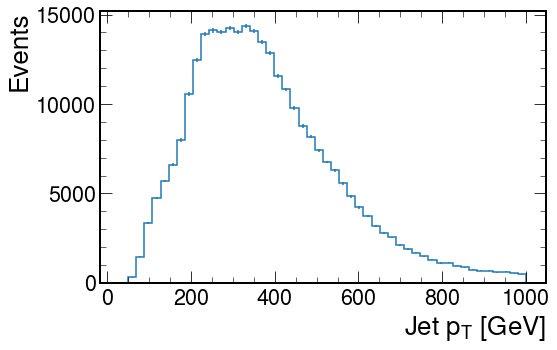

In [54]:
fig, ax = plt.subplots(figsize=(8,5))

jets[{"region":"high_mass"}].project("jet_pt").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

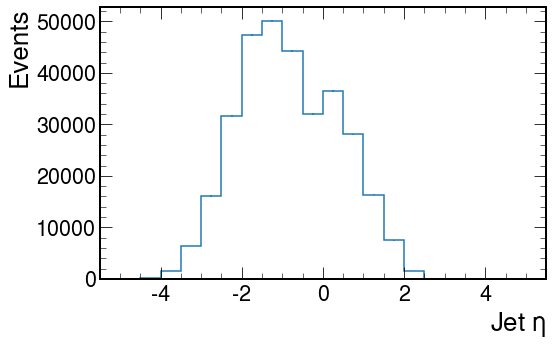

In [55]:
fig, ax = plt.subplots(figsize=(8,5))

jets[{"region":"high_mass"}].project("jet_eta").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

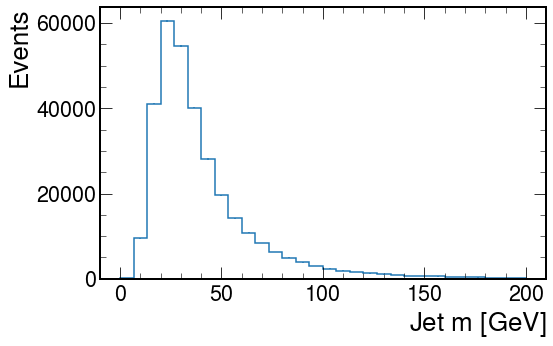

In [56]:
fig, ax = plt.subplots(figsize=(8,5))

jets[{"region":"high_mass"}].project("jet_mass").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

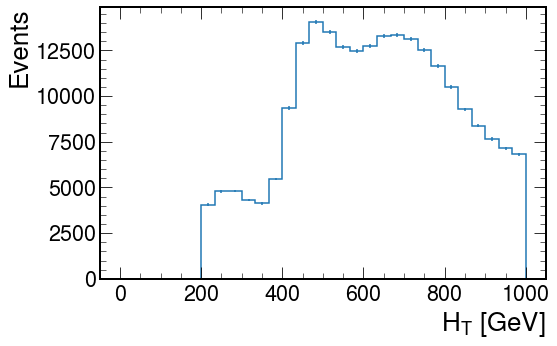

In [57]:
fig, ax = plt.subplots(figsize=(8,5))

jets[{"region":"high_mass"}].project("H").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

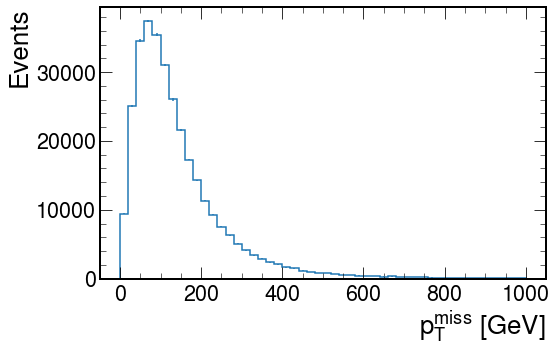

In [58]:
fig, ax = plt.subplots(figsize=(8,5))

met[{"region":"high_mass"}].project("met_pt").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

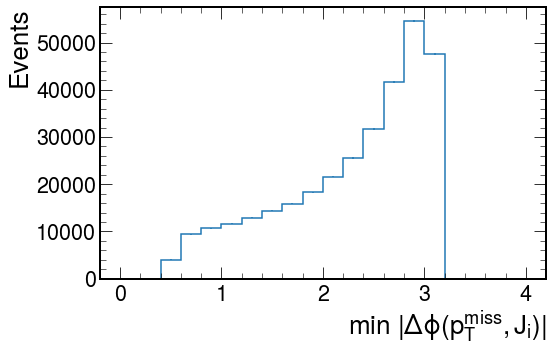

In [59]:
fig, ax = plt.subplots(figsize=(8,5))

met[{"region":"high_mass"}].project("minDeltaPhi").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

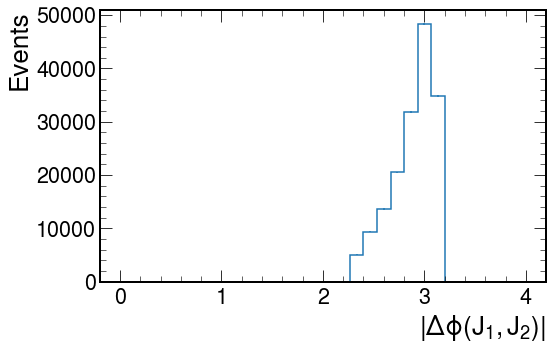

In [60]:
fig, ax = plt.subplots(figsize=(8,5))

dijet[{"region":"high_mass"}].project("leadingJetsDphi").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

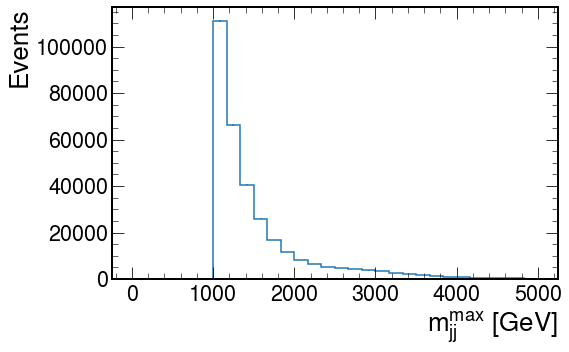

In [61]:
fig, ax = plt.subplots(figsize=(8,5))

dijet[{"region":"high_mass"}].project("invariantMass").plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

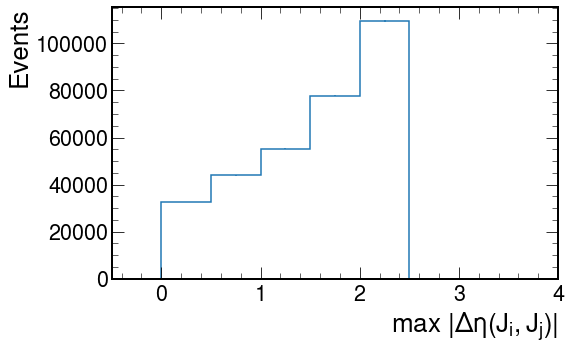

In [62]:
fig, ax = plt.subplots(figsize=(8,5))

dijet[{"region":"high_mass"}].project("maxDeltaEta").plot1d(ax=ax)

ax.set(
    ylabel="Events",
    xlim=(None, 4)
);

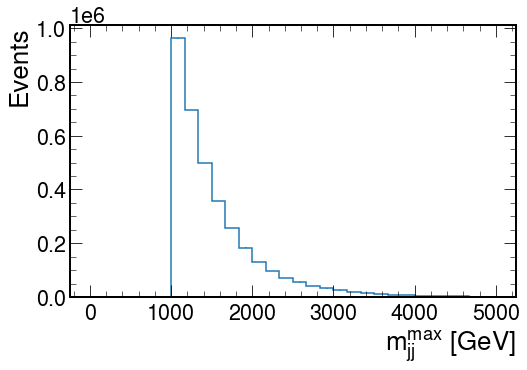

In [63]:
fig, ax = plt.subplots(figsize=(8,5))

# invariant mass after cut4 for high mass region
out["zjets"]["cutflow_invariantMass"][{"region":"high_mass","cut":4}].plot1d(ax=ax)

ax.set(
    ylabel="Events",
);

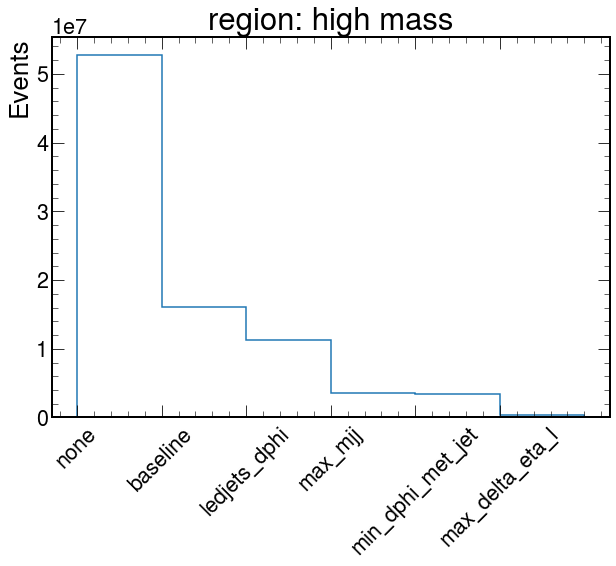

In [67]:
# cutflow
regions = {
    "high_mass": ["none", "baseline","ledjets_dphi","max_mjj","min_dphi_met_jet","max_delta_eta_l"],
    "low_mass": ["none", "baseline","ledjets_dphi","max_mjj","min_dphi_met_jet","max_delta_eta_r"],
}

plt.figure(figsize=(10,7))

out["zjets"]["cutflow"][{"region":"high_mass"}].project("cut").plot1d()

plt.xlabel(None)
plt.ylabel("Events")
plt.title(f"region: high mass")

plt.xticks(
    ticks=np.arange(len(regions["high_mass"])),
    labels=regions["high_mass"],
)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, ha="center");